In [ ]:
import os
import json
import numpy as np
import torch.nn as nn
import cv2
import torch
import shutil
import random
import pathlib
from tqdm import tqdm
import json
from PIL import Image
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pathlib import Path
import pandas as pd

In [4]:
PROJECT_DIR = "/ediss_data/ediss4/sarosh/mira/Thesis"

### YOLO

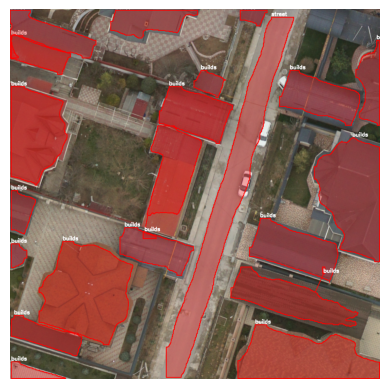

In [14]:
def plot_yolo_segmentation(image_path, label_path, class_names=None):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Read YOLO segmentation labels
    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        cls = int(parts[0])
        coords = list(map(float, parts[1:]))

        # Convert normalized points to pixel coordinates
        points = [(int(coords[i] * w), int(coords[i+1] * h)) for i in range(0, len(coords), 2)]
        points = np.array(points, dtype=np.int32)

        # Draw polygon
        cv2.polylines(img, [points], isClosed=True, color=(255, 0, 0), thickness=2)

        # Optionally fill polygon with transparency
        overlay = img.copy()
        cv2.fillPoly(overlay, [points], color=(255, 0, 0))
        img = cv2.addWeighted(overlay, 0.3, img, 0.7, 0)

        # Put class label
        if class_names:
            x, y = points[0]
            cv2.putText(img, class_names[cls], (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.6, (255, 255, 255), 2)

    # Show result
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# Example usage
import numpy as np
plot_yolo_segmentation(r"/ediss_data/ediss4/sarosh/mira/Thesis/yolo_images_Shymkent/Shymkent_5cm_16_28_tile_12_8.png", r"/ediss_data/ediss4/sarosh/mira/Thesis/runs/segment/predict3/labels/Shymkent_5cm_16_28_tile_12_8.txt", class_names=["builds", "street"])


In [4]:
# Load CSV
csv_path = PROJECT_DIR + "/runs/segment/train_80_new/results.csv"
df = pd.read_csv(csv_path)

df['F1(B)'] = 2 * (df['metrics/precision(B)'] * df['metrics/recall(B)']) / \
                 (df['metrics/precision(B)'] + df['metrics/recall(B)'])

df['F1(M)'] = 2 * (df['metrics/precision(M)'] * df['metrics/recall(M)']) / \
                 (df['metrics/precision(M)'] + df['metrics/recall(M)'])

df['IoU(B)'] = 1 / (1/df['metrics/precision(B)'] + 1/df['metrics/recall(B)'] - 1)
df['IoU(M)'] = 1 / (1/df['metrics/precision(M)'] + 1/df['metrics/recall(M)'] - 1)

output_path = PROJECT_DIR +"/runs/segment/train_80_new/results_with_f1_iou.csv"
df.to_csv(output_path, index=False)
print(f"Saved updated metrics to {output_path}")

Saved updated metrics to /ediss_data/ediss4/sarosh/mira/Thesis/runs/segment/train_80_new/results_with_f1_iou.csv


In [78]:
!yolo segment predict model={PROJECT_DIR}"/runs/segment/train_80_new/weights/best.pt" source={PROJECT_DIR}"/yolo_images_Shymkent/Shymkent_5cm_10_26_tile_11_12.png" save=True save_txt=True
# predict with custom model

Ultralytics 8.3.180 🚀 Python-3.13.5 torch-2.7.1+cu118 CUDA:0 (Tesla V100-PCIE-16GB, 16151MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs

image 1/1 /ediss_data/ediss4/sarosh/mira/Thesis/yolo_images_Shymkent/Shymkent_5cm_10_26_tile_11_12.png: 640x640 7 buildss, 1 street, 7.0ms
Speed: 6.1ms preprocess, 7.0ms inference, 380.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict6
1 label saved to runs/segment/predict6/labels
💡 Learn more at https://docs.ultralytics.com/modes/predict


### YOLO postprocessing

In [ ]:
import cv2

def resize_image_to_640(image_path, save_path=None):
    """
    Resize an image to 640x640 pixels.

    Args:
        image_path (str): Path to the input image.
        save_path (str, optional): Path to save the resized image. 
                                   If None, the image is not saved.

    Returns:
        resized_img (numpy.ndarray): The resized image.
    """
    # Read image
    img = cv2.imread(image_path)

    # Resize to 640x640
    resized_img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)

    # Save if path provided
    if save_path:
        cv2.imwrite(save_path, resized_img)

    return resized_img
resized = resize_image_to_640(
    PROJECT_DIR+"/yolo_images_Shymkent/Shymkent_5cm_17_28_tile_7_3.png",
    save_path=PROJECT_DIR+"/resized_17_7.png"
)

In [5]:
def load_yolo_seg_txt(txt_file, img_width, img_height):
    """
    Load YOLOv11-Seg polygons from a txt annotation file.
    Returns list of dicts: [{class_id, polygon}, ...]
    """
    annotations = []
    with open(txt_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            coords = np.array(list(map(float, parts[1:])))
            # Convert normalized to pixel coordinates
            xs = (coords[0::2] * img_width).astype(int)
            ys = (coords[1::2] * img_height).astype(int)
            polygon = np.stack([xs, ys], axis=1)
            annotations.append({"class": cls, "polygon": polygon})
    return annotations
anns_polygons = load_yolo_seg_txt(r"/ediss_data/ediss4/sarosh/mira/Thesis/runs/segment/predict4/labels/Shymkent_5cm_13_34_tile_7_12.txt", 640, 640)

In [6]:
# Axis-Aligned Bounding Boxes (AABB)
def polygon_to_aabb(polygon):
    x_min, y_min = polygon.min(axis=0)
    x_max, y_max = polygon.max(axis=0)
    return (x_min, y_min, x_max, y_max)

# Oriented Bounding Boxes (OBB)
def polygon_to_rotated_bbox(polygon):
    rect = cv2.minAreaRect(polygon.astype(np.float32))  
    box = cv2.boxPoints(rect)  
    return np.int_(box)  # 4 corners

anns_aabbs = [polygon_to_aabb(ann['polygon']) for ann in anns_polygons]
anns_obbs = [polygon_to_rotated_bbox(ann['polygon']) for ann in anns_polygons]

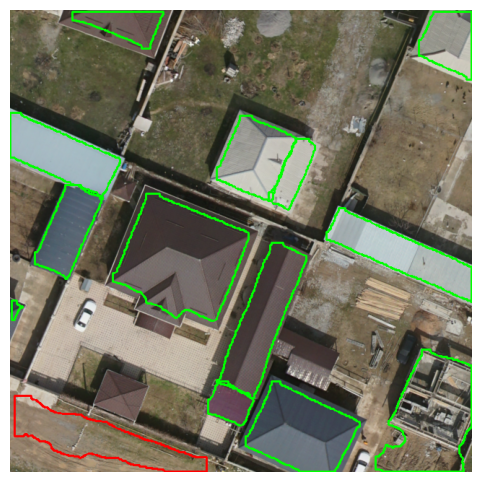

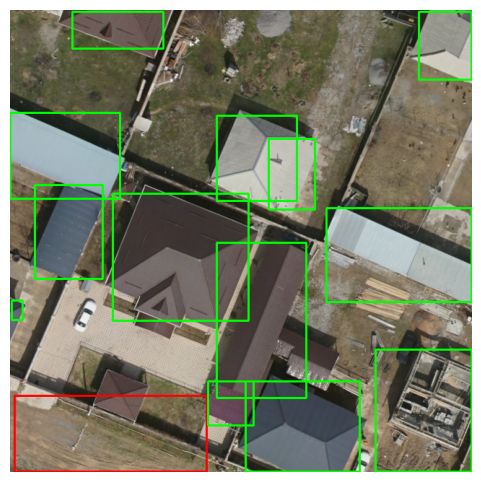

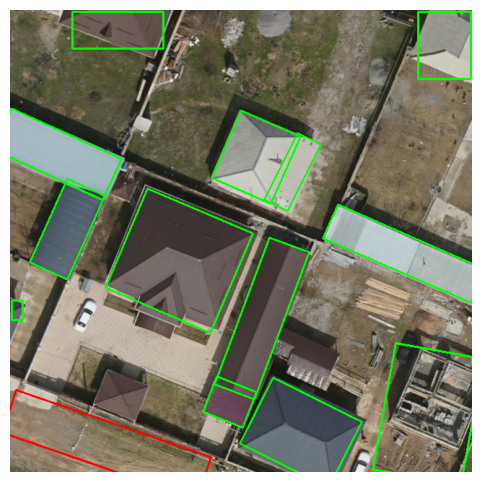

In [9]:
def visualize_annotations(img, annotations, mode="polygon", class_names=None, color=(0,255,0),
                          save_path=None, dpi=200):
    """
    Visualize YOLOv11-Seg annotations on an image.
    """
    img_vis = img.copy()
    
    for ann in annotations:
        poly = ann["polygon"]
        cls = ann["class"]

        # Choose color based on class
        if cls == 0:
            color = (0, 255, 0)   # Green for buildings
        elif cls == 1:
            color = (0, 0, 255)   # Red for streets (BGR format in cv2)
        else:
            color = (0, 255, 255)
        
        if mode == "polygon":
            cv2.polylines(img_vis, [poly], isClosed=True, color=color, thickness=2)
            
        elif mode == "aabb":
            x_min, y_min = poly.min(axis=0)
            x_max, y_max = poly.max(axis=0)
            cv2.rectangle(img_vis, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 2)
            
        elif mode == "rotated":
            rect = cv2.minAreaRect(poly.astype(np.float32))
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.polylines(img_vis, [box], isClosed=True, color=color, thickness=2)
        
        # Add class text if available
        if class_names:
            name = class_names.get(cls, str(cls))
            x, y = poly[0]
            cv2.putText(img_vis, name, (int(x), int(y)-5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # Convert BGR->RGB if needed
    if img_vis.shape[2] == 3:
        img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(img_vis); plt.axis("off")
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)
# Load your image (example with cv2)
img = cv2.imread(PROJECT_DIR+"/resized_7.png")

# Plot polygons
visualize_annotations(img, anns_polygons, mode="polygon", save_path=PROJECT_DIR + "/polygon_YOLO2")

# Plot AABB bounding boxes
visualize_annotations(img, anns_polygons, mode="aabb")

# Plot rotated bounding boxes
visualize_annotations(img, anns_polygons, mode="rotated", save_path=PROJECT_DIR + "/rotated_YOLO2")

### YOLO street polygons to centerlines

In [44]:
from shapely.geometry import LineString, Polygon
from skimage.draw import polygon as skpolygon
from skimage.morphology import skeletonize
import sknw

def yolo_polygon_to_mask(polygon, img_shape):
    """Convert YOLO polygon (Nx2) to binary mask"""
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    rr, cc = skpolygon(polygon[:,1], polygon[:,0], mask.shape)
    mask[rr, cc] = 1
    return mask

def polygon_to_centerlines_yolo(polygon, img_shape, min_length=10):
    """
    Convert a YOLO polygon to centerline (LineString)
    """
    mask = yolo_polygon_to_mask(polygon, img_shape)
    skeleton = skeletonize(mask).astype(np.uint8)
    graph = sknw.build_sknw(skeleton, multi=True)
    
    lines = []
    for (s, e, k) in graph.edges(keys=True):
        pts = graph.edges[s, e, k]['pts']
        length = np.sum(np.sqrt(np.sum(np.diff(pts, axis=0)**2, axis=1)))
        if length >= min_length:
            lines.append(LineString([(p[1], p[0]) for p in pts]))  # (x, y)
    return lines

def smooth_lines(lines, tolerance=2.0):
    """Simplify LineStrings to reduce zig-zags"""
    return [line.simplify(tolerance, preserve_topology=True) for line in lines]


In [45]:
def visualize_yolo_with_centerlines(img, anns, class_colors=None, show_centerlines=True,
                                    min_length=10, smooth_tol=2.0):
    """
    Visualize YOLO polygons and optionally street centerlines (class 1)
    """
    img_vis = img.copy()
    if class_colors is None:
        class_ids = set([ann['class'] for ann in anns])
        class_colors = {cls: tuple(np.random.randint(0,256,3).tolist()) for cls in class_ids}

    for ann in anns:
        poly = ann['polygon']
        cls = ann['class']
        color = class_colors.get(cls, (0,255,0))

        if cls != 1:  # buildings or other classes
            cv2.polylines(img_vis, [poly], isClosed=True, color=color, thickness=2)
        else:  # street
            if show_centerlines:
                lines = polygon_to_centerlines_yolo(poly, img_vis.shape, min_length=min_length)
                lines = smooth_lines(lines, tolerance=smooth_tol)
                for line in lines:
                    coords = np.array(line.coords, np.int32)
                    cv2.polylines(img_vis, [coords], isClosed=False, color=color, thickness=2)

    plt.figure(figsize=(8,8))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


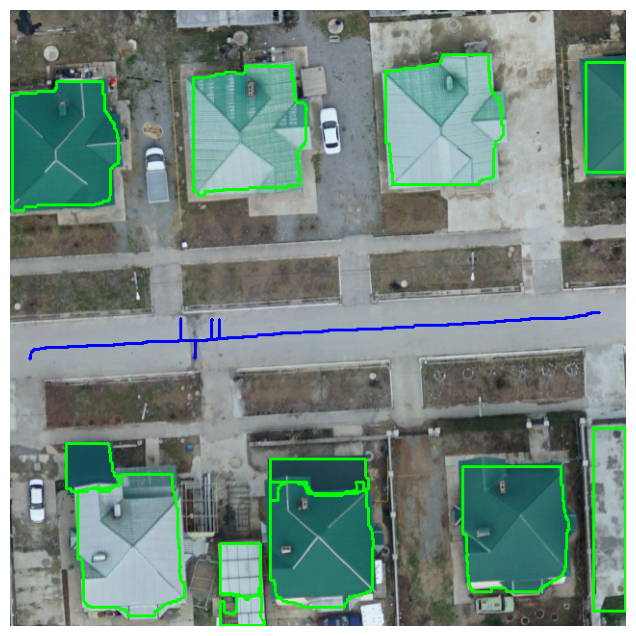

In [53]:
img = cv2.imread(r"/ediss_data/ediss4/sarosh/mira/Thesis/training_20_pretrained_cosine_check/val_predictions_epoch_20/val_49_6_image.png")
anns_polygons = load_yolo_seg_txt(r"/ediss_data/ediss4/sarosh/mira/Thesis/runs/segment/predict2/labels/Shymkent_5cm_9_27_tile_7_0.txt", img.shape[1], img.shape[0])

# Define colors (buildings green, streets red)
class_colors = {0: (0,255,0), 1: (255,0,0)}

visualize_yolo_with_centerlines(img, anns_polygons, class_colors,
                                show_centerlines=True, min_length=1, smooth_tol=0.5)


### UNET

In [82]:
from PIL import Image
from shapely.geometry import Polygon, box

def mask_to_polygons(mask, class_id):
    """Return polygons for a specific class in a multi-class mask"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [Polygon(cnt.squeeze()) for cnt in contours if cnt.shape[0] > 2]
    return polygons

def mask_to_aabbs(mask, class_id):
    """Return axis-aligned bounding boxes for a specific class"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    aabbs = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aabbs.append((x, y, x+w, y+h))
    return aabbs

def mask_to_rotated_boxes(mask, class_id):
    """Return rotated bounding boxes for a specific class"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rotated_boxes = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box_pts = cv2.boxPoints(rect).astype(int)
        rotated_boxes.append(box_pts)
    return rotated_boxes


#img_path = PROJECT_DIR + "/training_20_pretrained_cosine_check/val_predictions_epoch_20/val_49_6_image.png"
#mask_path = PROJECT_DIR + "/training_20_pretrained_cosine_check/val_predictions_epoch_20/val_49_6_pred.png"

# Load image and multi-class mask
img = np.array(Image.open(PROJECT_DIR + "/training_20_pretrained_cosine_check/val_predictions_epoch_20/val_0_7_image.png").convert("RGB"))
mask = np.array(Image.open(PROJECT_DIR + "/training_20_pretrained_cosine_check/val_predictions_epoch_20/val_0_7_pred.png"))


In [83]:
from shapely.geometry import Polygon
from shapely.ops import unary_union

def merge_mask_by_buffer(mask, class_id, buf_px=4, min_area=50, simplify_tol=0.0):
    """Merge nearby components of a class mask using buffer/unbuffer."""
    cls = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(cls, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    polys = []
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:   # drop tiny specks
            continue
        pts = cnt.squeeze()
        if pts.ndim != 2 or len(pts) < 3:
            continue
        polys.append(Polygon(pts))

    if not polys:
        return np.zeros_like(cls), []

    merged = unary_union(polys).buffer(buf_px)        # dilate
    merged = merged.buffer(-buf_px)                   # erode back
    if simplify_tol > 0:
        merged = merged.simplify(simplify_tol)

    # rasterize back to mask
    out = np.zeros_like(cls)
    geoms = [merged] if merged.geom_type == "Polygon" else list(merged.geoms)
    for g in geoms:
        c = np.array(g.exterior.coords).round().astype(np.int32)
        cv2.fillPoly(out, [c], 1)

    return out, geoms


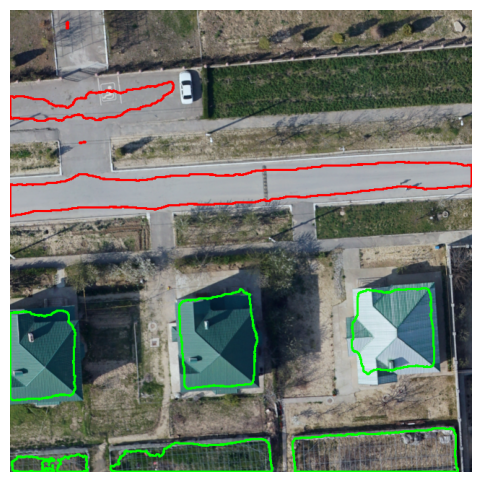

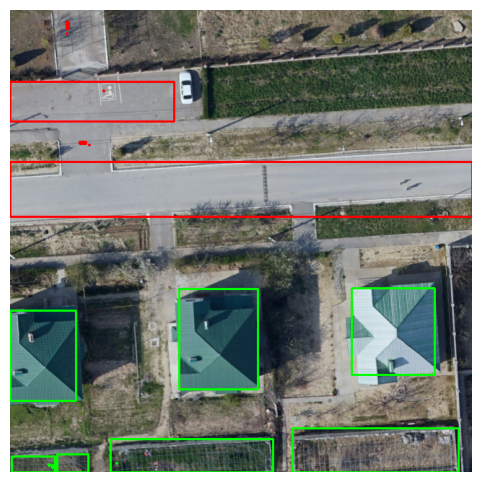

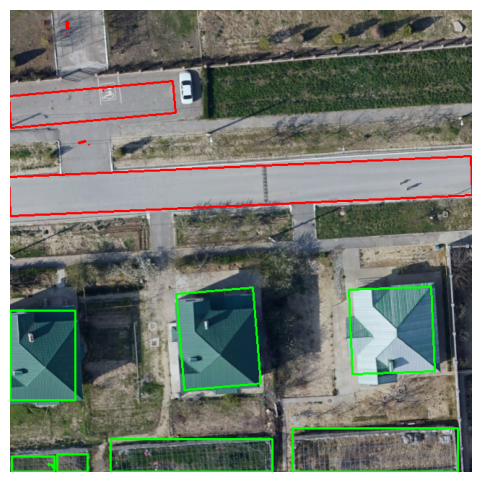

In [84]:
import matplotlib.pyplot as plt

def visualize_multiclass_outputs(img, mask, class_colors=None, 
                                 show_polygons=True, show_aabb=False, show_rotated=False,
                                 save_path=None, dpi=200):
    """
    Visualize multi-class mask outputs: polygons, AABB, rotated boxes.
    """
    img_vis = img.copy()
    if class_colors is None:
        # Default: random colors
        class_ids = np.unique(mask)
        class_colors = {cls: tuple(np.random.randint(0,256,3).tolist()) for cls in class_ids if cls != 2}

    for cls, color in class_colors.items():
        if show_polygons:
            polygons = mask_to_polygons(mask, cls)
            for poly in polygons:
                pts = np.array(poly.exterior.coords, np.int32)
                cv2.polylines(img_vis, [pts], isClosed=True, color=color, thickness=2)
        
        if show_aabb:
            boxes = mask_to_aabbs(mask, cls)
            for x_min, y_min, x_max, y_max in boxes:
                cv2.rectangle(img_vis, (x_min, y_min), (x_max, y_max), color, 2)
        
        if show_rotated:
            boxes = mask_to_rotated_boxes(mask, cls)
            for box_pts in boxes:
                cv2.polylines(img_vis, [box_pts], isClosed=True, color=color, thickness=2)
    
    fig = plt.figure(figsize=(6,6))
    plt.imshow(img_vis); plt.axis("off")
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# Define colors for classes (0=building, 1=road)
class_colors = {0: (0,255,0), 1: (255,0,0)}
roads_merged_mask, roads_polys = merge_mask_by_buffer(mask, class_id=1, buf_px=200, min_area=150)
# Replace the road layer in your mask
mask_connected = mask.copy()
mask_connected[mask == 2] = 2
mask_connected[roads_merged_mask == 1] = 1
# Visualize polygons only
visualize_multiclass_outputs(img, mask, class_colors, show_polygons=True, save_path = PROJECT_DIR + "/polygon_UNET4")

# Visualize polygons + axis-aligned boxes
visualize_multiclass_outputs(img, mask, class_colors, show_polygons=False, show_aabb=True)

# Visualize all three: polygons, AABB, rotated
visualize_multiclass_outputs(img, mask, class_colors, show_polygons=False, show_aabb=False, show_rotated=True, save_path = PROJECT_DIR + "/rotated_UNET4")

### SAM2 post-processing

In [85]:
# -----------------------------
# Helper functions to extract shapes
# -----------------------------
def mask_to_polygons(mask, class_id):
    """Return polygons for a specific class in a multi-class mask"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [Polygon(cnt.squeeze()) for cnt in contours if cnt.shape[0] > 2]
    return polygons

def mask_to_aabbs(mask, class_id):
    """Return axis-aligned bounding boxes for a specific class"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    aabbs = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aabbs.append((x, y, x+w, y+h))
    return aabbs

def mask_to_rotated_boxes(mask, class_id):
    """Return rotated bounding boxes for a specific class"""
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rotated_boxes = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box_pts = cv2.boxPoints(rect).astype(int)
        rotated_boxes.append(box_pts)
    return rotated_boxes

# -----------------------------
# Visualization functions
# -----------------------------
def draw_polygons(img, mask, class_colors, save_path=None, dpi=200):
    img_vis = img.copy()
    for cls, color in class_colors.items():
        polygons = mask_to_polygons(mask, cls)
        for poly in polygons:
            pts = np.array(poly.exterior.coords, np.int32)
            cv2.polylines(img_vis, [pts], isClosed=True, color=color, thickness=2)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(img_vis); plt.axis("off")
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show(); plt.close(fig)
    return img_vis

def draw_aabbs(img, mask, class_colors):
    img_vis = img.copy()
    for cls, color in class_colors.items():
        boxes = mask_to_aabbs(mask, cls)
        for x_min, y_min, x_max, y_max in boxes:
            cv2.rectangle(img_vis, (x_min, y_min), (x_max, y_max), color, 2)
    plt.figure(figsize=(6,6))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title("Axis-Aligned Bounding Boxes")
    plt.show()
    return img_vis

def draw_rotated_boxes(img, mask, class_colors, save_path=None, dpi=200):
    img_vis = img.copy()
    for cls, color in class_colors.items():
        boxes = mask_to_rotated_boxes(mask, cls)
        for pts in boxes:
            cv2.polylines(img_vis, [pts], isClosed=True, color=color, thickness=2)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(img_vis); plt.axis("off")
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show(); plt.close(fig)
    return img_vis


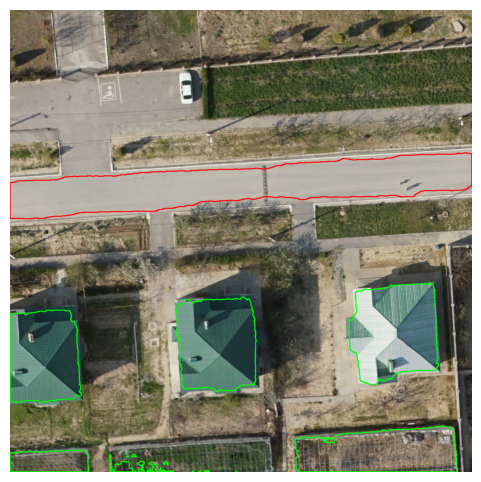

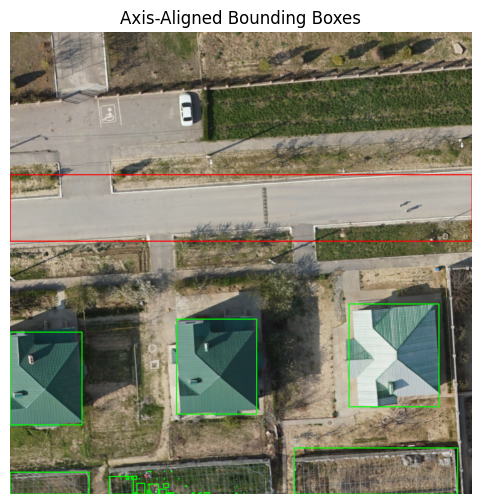

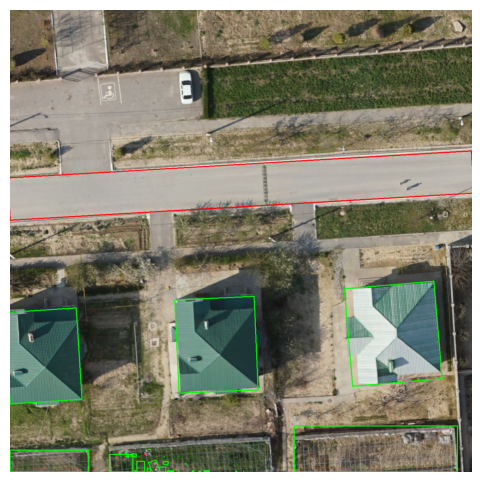

array([[[ 99,  94,  61],
        [100,  94,  63],
        [102,  94,  62],
        ...,
        [146, 125,  96],
        [140, 121,  91],
        [137, 120,  89]],

       [[100,  95,  61],
        [103,  97,  65],
        [110, 101,  68],
        ...,
        [145, 124,  93],
        [139, 121,  89],
        [136, 120,  88]],

       [[109, 104,  71],
        [111, 104,  71],
        [113, 104,  69],
        ...,
        [147, 126,  95],
        [140, 124,  90],
        [140, 123,  91]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [103,  99,  85],
        ...,
        [ 31,  26,  25],
        [ 31,  30,  26],
        [ 32,  31,  28]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 30,  29,  28],
        [ 29,  30,  26],
        [ 28,  28,  25]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [ 29,  30,  29],
        [ 27,  29,  27],
        [ 27,  27,  25]]

In [86]:
# Load saved predicted mask
mask = cv2.imread(PROJECT_DIR + "/segment-anything-2/predicted_labels_multiclass/Shymkent_5cm_10_26_tile_11_12_pred.png", cv2.IMREAD_UNCHANGED)
img = cv2.imread(PROJECT_DIR + "/yolo_images_Shymkent/Shymkent_5cm_10_26_tile_11_12.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define colors for classes
class_colors = {1: (0,255,0), 2: (255,0,0)}

roads_merged_mask, roads_polys = merge_mask_by_buffer(mask, class_id=2, buf_px=50, min_area=150)
# Replace the road layer in your mask
mask_connected = mask.copy()
mask_connected[mask == 2] = 0
mask_connected[roads_merged_mask == 1] = 2

# then call your draw_aabbs / draw_rotated_boxes on mask_connected
draw_polygons(img, mask_connected, class_colors, save_path = PROJECT_DIR + "/polygon_SAM23")
draw_aabbs(img, mask_connected, class_colors)
draw_rotated_boxes(img, mask_connected, class_colors, save_path = PROJECT_DIR + "/rotated_SAM23")


### UNET street polygons to centerlines

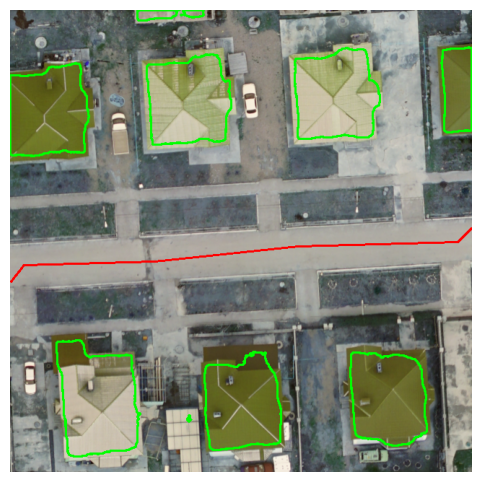

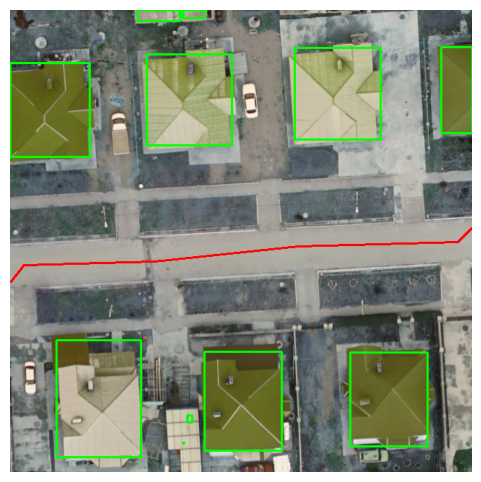

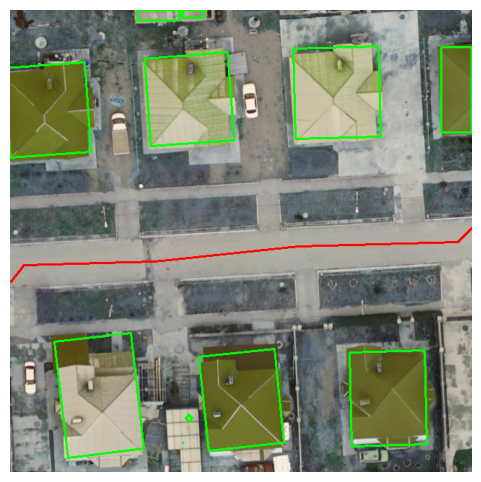

In [41]:
from shapely.geometry import Polygon, LineString
from skimage.morphology import skeletonize
import sknw

def mask_to_polygons(mask, class_id):
    """Return polygons for a specific class in a multi-class mask (buildings only)"""
    if class_id == 1:
        raise ValueError("Use mask_to_centerlines for streets (class 1)")
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [Polygon(cnt.squeeze()) for cnt in contours if cnt.shape[0] > 2]
    return polygons

def mask_to_aabbs(mask, class_id):
    """Return axis-aligned bounding boxes for a specific class (buildings only)"""
    if class_id == 1:
        raise ValueError("Use mask_to_centerlines for streets (class 1)")
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    aabbs = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aabbs.append((x, y, x+w, y+h))
    return aabbs

def mask_to_rotated_boxes(mask, class_id):
    """Return rotated bounding boxes for a specific class (buildings only)"""
    if class_id == 1:
        raise ValueError("Use mask_to_centerlines for streets (class 1)")
    class_mask = (mask == class_id).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rotated_boxes = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box_pts = cv2.boxPoints(rect).astype(int)
        rotated_boxes.append(box_pts)
    return rotated_boxes

def mask_to_centerlines(mask, street_class=1, min_length=10):
    """
    Convert street polygons (from mask) into centerlines (LineStrings)
    Prunes short branches (less than min_length pixels)
    """
    street_mask = (mask == street_class).astype(np.uint8)
    skeleton = skeletonize(street_mask).astype(np.uint8)
    graph = sknw.build_sknw(skeleton, multi=True)

    lines = []
    for (s, e, k) in graph.edges(keys=True):
        pts = graph.edges[s, e, k]['pts']
        # compute edge length
        length = np.sum(np.sqrt(np.sum(np.diff(pts, axis=0)**2, axis=1)))
        if length >= min_length:
            lines.append(LineString([(p[1], p[0]) for p in pts]))
    return lines
def smooth_lines(lines, tolerance=2.0):
    """
    Simplify line using shapely's simplify method
    """
    smoothed = [line.simplify(tolerance, preserve_topology=True) for line in lines]
    return smoothed

def visualize_multiclass_outputs(img, mask, class_colors=None, 
                                 show_polygons=True, show_aabb=False, show_rotated=False, show_centerlines=True):
    """
    Visualize multi-class mask outputs: 
    - buildings (polygons, AABB, rotated boxes)
    - streets (centerlines)
    """
    img_vis = img.copy()
    
    if class_colors is None:
        # Default: random colors
        class_ids = np.unique(mask)
        class_colors = {cls: tuple(np.random.randint(0,256,3).tolist()) for cls in class_ids if cls != 2}

    for cls, color in class_colors.items():
        if cls == 0:  # buildings
            if show_polygons:
                polygons = mask_to_polygons(mask, cls)
                for poly in polygons:
                    pts = np.array(poly.exterior.coords, np.int32)
                    cv2.polylines(img_vis, [pts], isClosed=True, color=color, thickness=2)
            if show_aabb:
                boxes = mask_to_aabbs(mask, cls)
                for x_min, y_min, x_max, y_max in boxes:
                    cv2.rectangle(img_vis, (x_min, y_min), (x_max, y_max), color, 2)
            if show_rotated:
                boxes = mask_to_rotated_boxes(mask, cls)
                for box_pts in boxes:
                    cv2.polylines(img_vis, [box_pts], isClosed=True, color=color, thickness=2)

        elif cls == 1:  # streets
            if show_centerlines:
                lines = mask_to_centerlines(mask, street_class=1, min_length=10)
                lines = smooth_lines(lines, tolerance=5.0)
                for line in lines:
                    coords = np.array(line.coords, np.int32)
                    cv2.polylines(img_vis, [coords], isClosed=False, color=color, thickness=2)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img_vis)
    plt.axis("off")
    plt.show()

# Define colors for classes (0=building, 1=road)
class_colors = {0: (0,255,0), 1: (255,0,0)}

# Visualize polygons only
visualize_multiclass_outputs(img, mask, class_colors, show_polygons=True)

# Visualize polygons + axis-aligned boxes
visualize_multiclass_outputs(img, mask, class_colors, show_polygons=False, show_aabb=True)

# Visualize all three: polygons, AABB, rotated
visualize_multiclass_outputs(img, mask, class_colors, show_polygons=False, show_aabb=False, show_rotated=True)